Copyright (C) 2024  Adam Jones  All Rights Reserved

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import figure_standard
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
import os

In [2]:
n_boot = 10001
figure_standard.standardize_plot_settings()
main_palette = figure_standard.create_main_palette()

In [3]:
# load data
df_other = pd.read_excel("../2_intermediate_data/eegless_models.xlsx")
df_other = df_other[['stage_count', 'kappa', 'ball']]

# make sure they are sorted correctly
df_other = df_other.sort_values(by=['stage_count', 'kappa'], ascending=[False, False])

In [4]:
order = ['5-stage', '4-stage', '3-stage']


df_other.loc[df_other.stage_count==5, 'stage_count'] = order[0]
df_other.loc[df_other.stage_count==4, 'stage_count'] = order[1]
df_other.loc[df_other.stage_count==3, 'stage_count'] = order[2]

In [5]:
df_floor = pd.read_excel('../2_intermediate_data/time_only_floor.xlsx')
df_floor.loc[df_floor.stage_count==5, 'stage_count'] = order[0]
df_floor.loc[df_floor.stage_count==4, 'stage_count'] = order[1]
df_floor.loc[df_floor.stage_count==3, 'stage_count'] = order[2]
df_floor['dummy'] = 0
df_floor

,stage_count,kappa,dummy
0,5-stage,0.253529,0
1,4-stage,0.278913,0
2,3-stage,0.313331,0


In [6]:
all_label = '5-stage'

In [7]:
# load model data
model_df = pd.read_excel("../2_intermediate_data/main_model_data.xlsx")

# rename the stages
model_df = model_df.rename(columns={"o_kappa": all_label,"w_kappa": "Wake","n1_kappa": "N1","n2_kappa": "N2","n3_kappa": "N3","rem_kappa": "REM"})

# keep only the relevant columns
model_df = model_df.loc[model_df['set']==3, [all_label, 'Wake', 'N1', 'N2', 'N3', 'REM']].copy(deep=True)

model_df['collection'] = 'All subjects'

# melt the data
model_data = pd.melt(model_df, id_vars=['collection'], value_vars=[all_label, 'Wake', 'N1', 'N2', 'N3', 'REM'])


In [8]:
# load human data
human_df = pd.read_excel("../2_intermediate_data/human_data.xlsx")

# rename the stages
human_df = human_df.rename(columns={"o_kappa": all_label,"w_kappa": "Wake","s1_kappa": "N1","s2_kappa": "N2","sws_kappa": "N3","rem_kappa": "REM"})

# keep only the summary data
human_df = human_df[human_df.decade == -1]

# keep only the 2009 results
human_df = human_df.loc[human_df.paper == 2009]

human_df = human_df.drop(columns=['paper', 'decade', 'fake_subject']).copy(deep=True)

human_df['collection'] = 'All subjects'

# melt the data
human_data = pd.melt(human_df, id_vars=['collection'], value_vars=[all_label, 'Wake', 'N1', 'N2', 'N3', 'REM'])

In [9]:
# label the source
model_label = 'model (ECG)'
human_label = 'human (PSG)'

model_data['source'] = model_label
human_data['source'] = human_label

In [10]:
all_data = pd.concat([model_data, human_data], ignore_index=True).copy(deep=True)

# set the human to be below the x axis
all_data.loc[all_data.source == human_label, 'value'] = -all_data.loc[all_data.source == human_label, 'value']

# create a copy with the flip of that
all_data_flipped = all_data.copy(deep=True)
all_data_flipped['value'] = -all_data_flipped['value']

In [11]:
# just "null" out the flipped data (so stats are still computed and it takes up horizontal space)
all_data.loc[all_data.source == human_label, 'value'] = -0.5
all_data_flipped.loc[all_data_flipped.source == model_label, 'value'] = -0.5

In [12]:
df_bootstrap_data = pd.read_excel("../2_intermediate_data/5_4_3_bootstrap.xlsx")
df_bootstrap = pd.DataFrame(columns=['stage_count', 'median', 'lower', 'upper','dummy'])


for i, col in enumerate(['5_all', '4_all', '3_all']):
    df_bootstrap.loc[i] = [order[i], df_bootstrap_data[col].median(), df_bootstrap_data[col].quantile(0.025), df_bootstrap_data[col].quantile(1-0.025), 0]

df_bootstrap


,stage_count,median,lower,upper,dummy
0,5-stage,0.725657,0.715291,0.735450,0
1,4-stage,0.769609,0.759372,0.780146,0
2,3-stage,0.842337,0.829576,0.848490,0


1 extra bytes in post.stringData array
fdsc NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
just NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
fdsc NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
just NOT subset; don't know how to subset; dropped


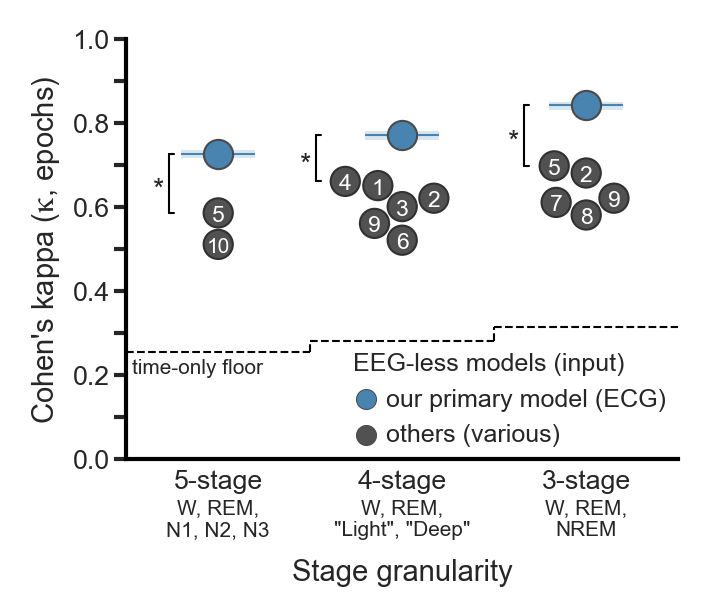

In [13]:

human_color = sns.color_palette("Greys", 7)[3]
peer_color = sns.color_palette("Greys", 7)[5]

# gs = gridspec.GridSpec(2, 5)
# ax1 = plt.subplot(gs[0, 0])
# ax2 = plt.subplot(gs[0, 2:])
# ax3 = plt.subplot(gs[1, :])


# dot size
size = 7.01  #7.35

palette_peer = [peer_color]*3

# plot the other data first, with jitter
ax_swarm = sns.swarmplot(data=df_other, x="stage_count", y="kappa", hue="stage_count",
    palette=palette_peer, order=order,
    size=size, linewidth=0.5,
    # ax=ax2,
    legend=True)

# plot the model data second, without jitter
sns.stripplot(data=df_bootstrap, x='stage_count', y='median',  
            palette=[main_palette[0]], 
            hue='dummy',
            order=order,
            ax=ax_swarm,
            size=size, linewidth=0.5, 
            legend=True, jitter=False)

# add the extra swarm annotations
min_color = 'black'
min_width = 0.5
line_style = '--'
vert_offset = 0.075
shade_width = 0.4

for i in range(3):
    # time only floor fline
    ax_swarm.axhline(df_floor.loc[i].kappa, color=min_color, xmin=i/3, xmax=(i+1)/3, linewidth=min_width, linestyle=line_style)

    xcenter = ((i+1)*2-1)/6
    # * marker
    # ax_swarm.text(xcenter, df_bootstrap.loc[i, 'median'] + vert_offset, "*", transform=ax_swarm.transAxes,
    #     fontsize=7, va='center', ha='center')

    # for the shaded area
    lower = df_bootstrap.loc[i, 'lower']
    height = df_bootstrap.loc[i, 'upper'] - lower
    rect = mpatches.Rectangle((i-shade_width/2, lower), shade_width, height, linewidth=0, edgecolor='none', 
                          alpha=0.2,
                          facecolor=main_palette[0])
    # Add the patch to the Axes
    ax_swarm.add_patch(rect)

    delta = shade_width/2/3
    # for the median line
    ax_swarm.axhline(df_bootstrap.loc[i, 'median'], color=main_palette[0], xmin=xcenter-delta, xmax=xcenter+delta, linewidth=0.5, 
                     solid_capstyle='butt',
                     linestyle='-')


# add the vertical lines
ax_swarm.axvline(x=.5, color=min_color, ymin=df_floor.loc[0].kappa, ymax=df_floor.loc[1].kappa, linewidth=min_width, linestyle=line_style)
ax_swarm.axvline(x=1.5, color=min_color, ymin=df_floor.loc[1].kappa, ymax=df_floor.loc[2].kappa, linewidth=min_width, linestyle=line_style)

# add text for floor
vert_loc = df_floor.loc[0].kappa - 0.015
ax_swarm.text(0.01, vert_loc, "time-only floor", transform=ax_swarm.transAxes,
      fontsize=5, va='top', ha='left')



# set labels and ylimits

ax_swarm.set_ylim([0, 1])
ax_swarm.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


for label in ax_swarm.get_yticklabels()[1::2]:
    label.set_visible(False)

# move the labels closer to the axis
for tick in ax_swarm.get_xticklabels():
    tick.set_verticalalignment("bottom")

# create the x labels                
# make labels bold
for i, label in enumerate(ax_swarm.xaxis.get_ticklabels()):
    if i > 3:
        continue
    tick_fontsize = label._fontproperties._size
    label.set_fontweight(None)
    # label.set_size(tick_fontsize*1)
    
# adjust the fontsize a little
sub_tick_fontsize = 5 # tick_fontsize * 0.75

y_offset = -0.095

ax_swarm.annotate("W, REM,\nN1, N2, N3", 
             xy=(1/6, y_offset), 
             xycoords='axes fraction',
             horizontalalignment="center",
             verticalalignment="top",
             fontsize=sub_tick_fontsize);
ax_swarm.annotate("W, REM,\n\"Light\", \"Deep\"", 
             xy=(0.5, y_offset), 
             xycoords='axes fraction',
             horizontalalignment="center",
             verticalalignment="top",
             fontsize=sub_tick_fontsize);
ax_swarm.annotate("W, REM,\nNREM\n", 
             xy=(5/6, y_offset), 
             xycoords='axes fraction',
             horizontalalignment="center",
             verticalalignment="top",
             fontsize=sub_tick_fontsize);



handles, labels = ax_swarm.get_legend_handles_labels()
handles_new = [handles[3]]
handles_new += [handles[2]]

for handle in handles_new:
    handle.set_edgecolor('#4a4a4a')
    handle.set_linewidth(0.25)

labels = ['our primary model (ECG)','others (various)']
ax_swarm.legend(handles_new, labels, 
    title='EEG-less models (input)', 
    title_fontproperties={'weight':None, 'size': 6}, 
    loc='lower right',
    alignment='left',
    borderpad=0,
    handletextpad=0.3,
    handlelength=1,
    fontsize=6)







labelpad = 2.5

ax_swarm.set_xlabel('')
ax_swarm.set_ylabel('Cohen\'s kappa ($\kappa$, epochs)', fontweight=None, labelpad=labelpad)

panel_label_y = 1.05
panel_label_x = -0.45
panel_fontsize = 8

panel_title_x = 0.5
title_fontsize = 7

sns.despine(ax=ax_swarm, right=True, top=True, bottom=False)

ax_swarm.grid(False)
ax_swarm.tick_params(axis='y', left=True, width=1, length=3, pad=1)


ax_swarm.text(0.5, -0.27, 'Stage granularity', 
        transform=ax_swarm.transAxes, 
      fontsize=title_fontsize, fontweight=None, va='center', ha='center')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0)
figure_standard.scale_figure_by_axes(ax_swarm, 1.4, 1.84)


# save the figure once
filename = os.path.basename(globals()["__vsc_ipynb_file__"]).replace(".ipynb", "")
figure_standard.save_figure_files(filename, save_png=False)
# the remaining annotations can only be correctly placed
# once the figure has been fully created


def add_label_to_dot(ax, points, labels, anno_size, print_coord=False):
    for i in range(points.shape[0]):
        label_str = str(labels[i])
        if len(label_str) > 1:
            cur_anno_size = anno_size - 0.5
        else:
            cur_anno_size = anno_size
        y_offset = -0.005
        if print_coord:
            print(points[i,0], points[i,1])
        ax.text(points[i,0], points[i,1] + y_offset, label_str, fontsize=cur_anno_size, va='center', ha='center', color='white')

anno_size = 5.5
points = ax_swarm._children[0]._offsets.data
labels = list(df_other.loc[df_other.stage_count==order[0]].ball)
add_label_to_dot(ax_swarm, points, labels, anno_size)

# flip the x-offsets for the 4-stage column
# this does not work
# offsets = ax_swarm._children[1].get_offsets().data
# offsets[:,0] = 2-offsets[:,0]
# ax_swarm._children[1].set_offsets(offsets)

points = ax_swarm._children[1]._offsets.data
labels = list(df_other.loc[df_other.stage_count==order[1]].ball)
add_label_to_dot(ax_swarm, points, labels, anno_size)

points = ax_swarm._children[2]._offsets.data
labels = list(df_other.loc[df_other.stage_count==order[2]].ball)
add_label_to_dot(ax_swarm, points, labels, anno_size)

def add_stat_markers(cat_i, x_offset=-0.33, flip=False):
    top_y = df_bootstrap.loc[cat_i, 'median']
    top_ball = ax_swarm._children[cat_i]._offsets.data[0, :]
    bottom_y = top_ball[1]


    vert_line_x = cat_i + x_offset

    ax_swarm.axvline(x=vert_line_x, ymin=bottom_y, ymax=top_y, color=min_color, linewidth=min_width, linestyle='-')

    xcenter = ((cat_i+1)*2-1)/6
    if not flip:
        xmin = xcenter + x_offset/3
        xmax = xmin+0.01
    else:
        xmax = xcenter + x_offset/3
        xmin = xmax-0.01
        
    ax_swarm.axhline(y=top_y, xmin=xmin, xmax=xmax, color=min_color,linewidth=min_width, linestyle='-')
    ax_swarm.axhline(y=bottom_y, xmin=xmin, xmax=xmax, color=min_color,linewidth=min_width, linestyle='-')

    star_offset = 0.03 if flip else -0.02
    ax_swarm.text(xmin + star_offset, (top_y+bottom_y)/2 -0.019, "*", transform=ax_swarm.transAxes,
            fontsize=7, va='center', ha='center')
    

    
add_stat_markers(0, -0.27, False)
add_stat_markers(1, -0.47, False)
add_stat_markers(2, -0.34, False)

# save the figure
filename = os.path.basename(globals()["__vsc_ipynb_file__"]).replace(".ipynb", "")
figure_standard.save_figure_files(filename)